## Problem Statement
## Perform sentimental analysis:
### Perform sentimental analysis on the Elon-musk tweets (Elon-musk.csv)

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 2. Import Dataset

In [2]:
tweets = pd.read_csv('Elon_musk.csv',encoding='cp1252')
tweets

,Unnamed: 0,Text
0,1,@kunalb11 I’m an alien
1,2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,3,@joerogan @Spotify Great interview!
3,4,@gtera27 Doge is underestimated
4,5,@teslacn Congratulations Tesla China for amazi...
...,...,...
1994,1995,"@flcnhvy True, it sounds so surreal, but the n..."
1995,1996,@PPathole Make sure to read ur terms &amp; con...
1996,1997,@TeslaGong @PPathole Samwise Gamgee
1997,1998,@PPathole Altho Dumb and Dumber is <U+0001F525...


In [3]:
tweets.drop(['Unnamed: 0'], inplace= True, axis= 1)
tweets

,Text
0,@kunalb11 I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...
...,...
1994,"@flcnhvy True, it sounds so surreal, but the n..."
1995,@PPathole Make sure to read ur terms &amp; con...
1996,@TeslaGong @PPathole Samwise Gamgee
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...


## 3. Data Exploration

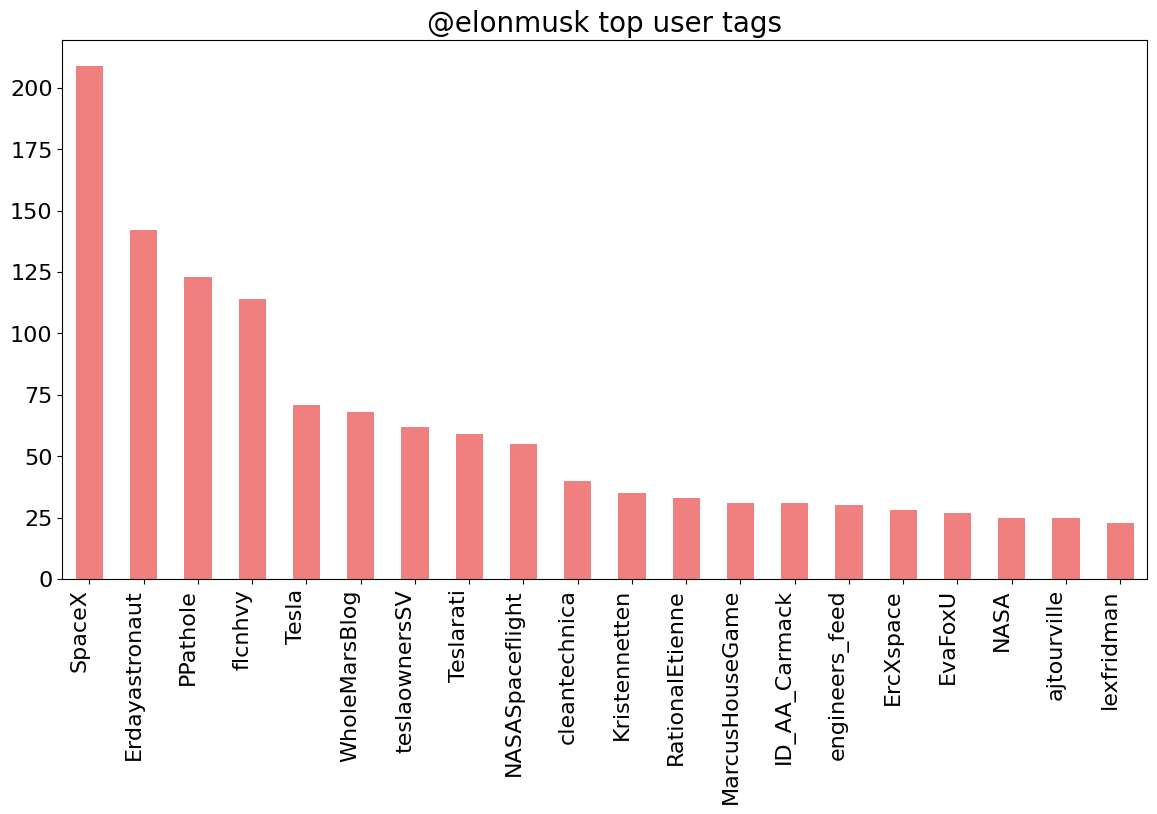

In [4]:
import itertools

c = list(itertools.chain(*tweets.Text.map(lambda t: [handle.replace(":", "")[1:] for handle in t.split(" ")
                                                     if '@' in handle.replace(":", "")]).tolist()))

pd.Series(c).value_counts().head(20).plot.bar(figsize=(14, 7), fontsize=16, color='lightcoral')
plt.gca().set_title('@elonmusk top user tags', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90, ha='right', fontsize=16)
pass

## 4. BasicText Preprocessing

### Cleaning the text by removing irrelevant information

In [5]:
import re #regular expression
import string

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub("[0-9" "]+"," ",text)
    text = re.sub('[‘’“”…]', '', text)
    return text

clean = lambda x: clean_text(x)

tweets["Text"] = tweets["Text"].apply(clean_text) # Clean The Text
tweets.head(11)

,Text
0,im an alien
1,idaacarmack ray tracing on cyberpunk with hdr ...
2,joerogan spotify great interview
3,doge is underestimated
4,teslacn congratulations tesla china for amazin...
5,happy new year of the ox
6,frodo was the underdoge\nall thought he would ...
7,owensparks flcnhvy haha thanks
8,flcnhvy indeed tweets definitely do not repre...
9,the most entertaining outcome is the most likely


### Word Frequency

In [6]:
freq = pd.Series(' '.join(tweets['Text']).split()).value_counts()[:20] # for top 20
freq

the               487
to                400
a                 356
is                355
of                315
spacex            239
in                219
amp               218
for               194
tesla             166
will              165
be                157
erdayastronaut    142
this              140
it                138
we                136
on                129
that              128
rt                127
but               126
dtype: int64

### Removing Stopwords

In [7]:
!python -m nltk.downloader stopwords

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
tweets['Text'] = tweets['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

### Word Frequency after Removal of Stopwords

In [9]:
freq_stp = pd.Series(' '.join(tweets['Text']).split()).value_counts()[:20] # for top 20
freq_stp

spacex             239
amp                218
tesla              166
erdayastronaut     142
rt                 127
ppathole           123
flcnhvy            114
yes                 86
great               76
teslaownerssv       73
wholemarsblog       68
teslarati           59
nasaspaceflight     55
haha                55
good                51
launch              49
sure                43
yeah                41
cleantechnica       40
would               40
dtype: int64

## 5. Basic Feature Extaction
### Count vectoriser tells the frequency of a word.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
vectorizer = CountVectorizer(min_df = 1, max_df = 0.9)
X = vectorizer.fit_transform(tweets["Text"])
word_freq_df = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'occurrences':np.asarray(X.sum(axis=0)).ravel().tolist()})
word_freq_df['frequency'] = word_freq_df['occurrences']/np.sum(word_freq_df['occurrences'])
word_freq_df.head(11)

,term,occurrences,frequency
0,aber,1,0.000076
1,able,6,0.000453
2,abo,1,0.000076
3,aboard,1,0.000076
4,abort,3,0.000227
5,absence,1,0.000076
6,absolute,1,0.000076
7,absolutely,15,0.001133
8,absorb,1,0.000076
9,absorption,1,0.000076


### TFIDF - Term frequency inverse Document Frequencyt

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features= 1000, max_df = 0.5, smooth_idf=True) #keep top 1000 words
doc_vec = vectorizer.fit_transform(tweets["Text"])
names_features = vectorizer.get_feature_names_out()
dense = doc_vec.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns = names_features)
df

,able,abort,absolutely,access,accurate,actual,actually,adamklotz,add,adding,...,yeah,year,years,yes,yesterdays,youre,yourfavgas,yup,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.356742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### N-gram
### Bi-gram

In [12]:
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2), max_features=2000).fit(corpus) #for tri-gram, put ngram_range=(3,3)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [13]:
top2_words = get_top_n2_words(tweets["Text"], n=200) #top 200
top2_df = pd.DataFrame(top2_words)
top2_df.columns = ["Bi-gram", "Freq"]
top2_df.head(11)

,Bi-gram,Freq
0,rt spacex,71
1,spacex falcon,17
2,erdayastronaut spacex,16
3,pretty much,12
4,rt nasa,12
5,waemd spacex,11
6,giga berlin,10
7,first stage,10
8,teslaratiteam teslarati,10
9,nasa spacex,9


### Bi-gram plot

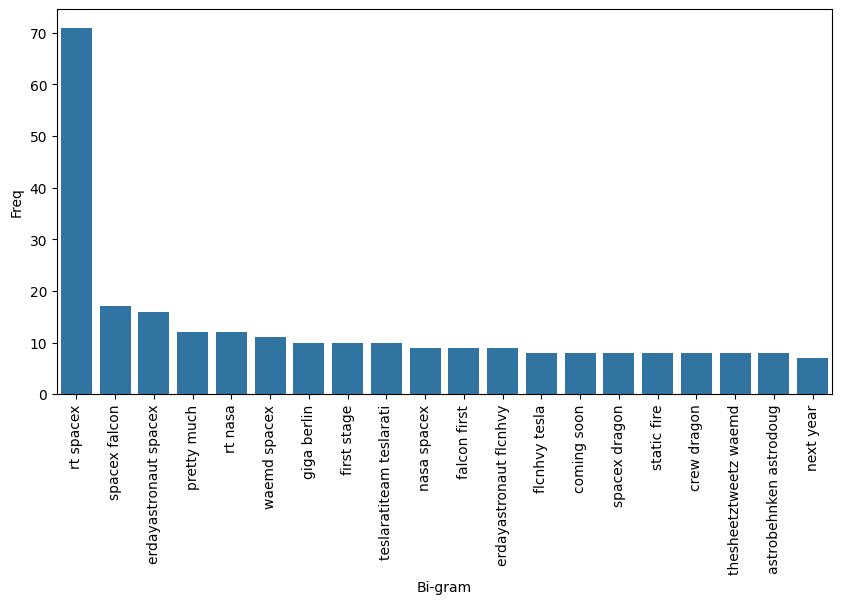

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
top20_bigram = top2_df.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot = sns.barplot(x=top20_bigram["Bi-gram"],y=top20_bigram["Freq"])
plot.set_xticklabels(rotation=90,labels = top20_bigram["Bi-gram"]);

### Tri-gram

In [15]:
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [16]:
top3_words = get_top_n3_words(tweets["Text"], n=200)
top3_df = pd.DataFrame(top3_words)
top3_df.columns = ["Tri-gram", "Freq"]
top3_df.head(11)

,Tri-gram,Freq
0,rt spacex falcon,17
1,falcon first stage,9
2,spacex falcon first,8
3,thesheetztweetz waemd spacex,8
4,course still love,7
5,ppathole thesheetztweetz waemd,7
6,waemd spacex spacexstarlink,7
7,first stage landed,6
8,rt spacex liftoff,6
9,spacex spacexstarlink wanationalguard,6


### Tri-gram plot

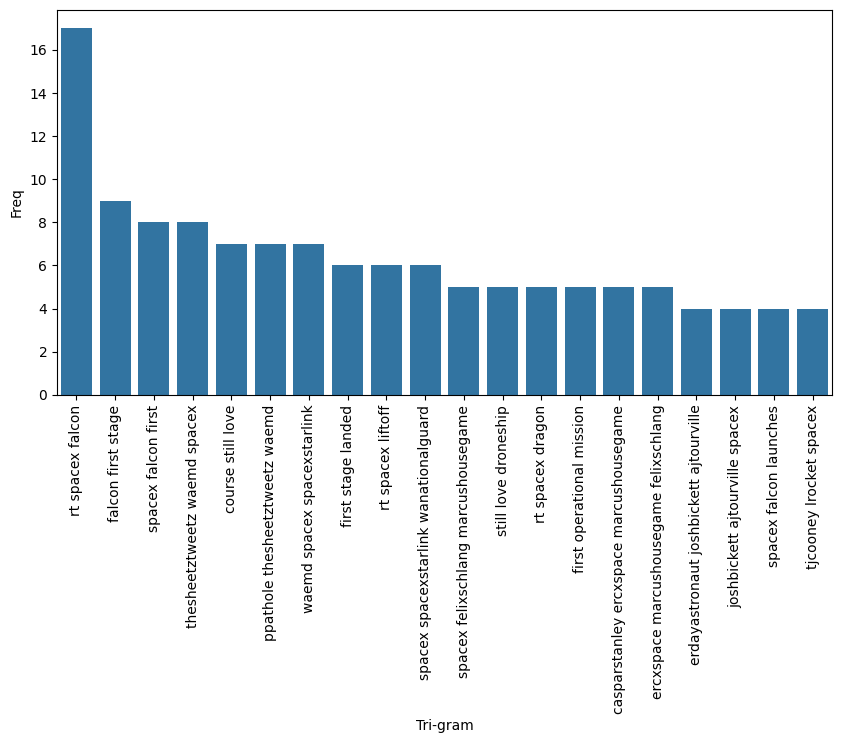

In [17]:
import seaborn as sns
top20_trigram = top3_df.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot = sns.barplot(x=top20_trigram["Tri-gram"],y=top20_trigram["Freq"])
plot.set_xticklabels(rotation=90,labels = top20_trigram["Tri-gram"]);

### Creating a Worlcloud

In [18]:
string_Total = " ".join(tweets["Text"])

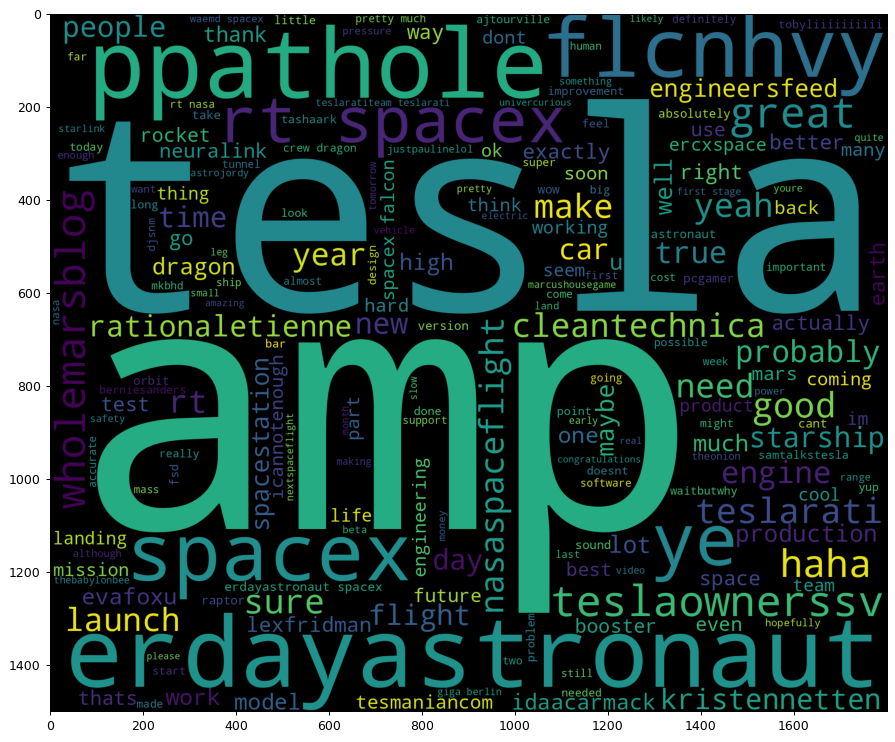

In [19]:
#wordcloud for entire corpus
from wordcloud import WordCloud
plt.figure(figsize=(12,12),dpi=90)
wordcloud_stw = WordCloud(background_color= 'black', width = 1800, height = 1500).generate(string_Total)
plt.imshow(wordcloud_stw);

### Subjectivity and Polarity

In [20]:
from textblob import TextBlob

# Get The Subjectivity
def sentiment_analysis(ds):
    sentiment = TextBlob(ds["Text"]).sentiment
    return pd.Series([sentiment.subjectivity, sentiment.polarity])

# Adding Subjectivity & Polarity
tweets[["subjectivity", "polarity"]] = tweets.apply(sentiment_analysis, axis=1)
tweets.head(11)

,Text,subjectivity,polarity
0,im alien,0.750000,-0.250000
1,idaacarmack ray tracing cyberpunk hdr nextleve...,0.000000,0.000000
2,joerogan spotify great interview,0.750000,0.800000
3,doge underestimated,0.000000,0.000000
4,teslacn congratulations tesla china amazing ex...,0.322222,0.200000
5,happy new year ox,0.727273,0.468182
6,frodo underdoge thought would fail httpstcozgx...,0.300000,-0.500000
7,owensparks flcnhvy haha thanks,0.250000,0.200000
8,flcnhvy indeed tweets definitely represent rea...,0.500000,0.000000
9,entertaining outcome likely,0.850000,0.250000


### Creating a Worlcloud

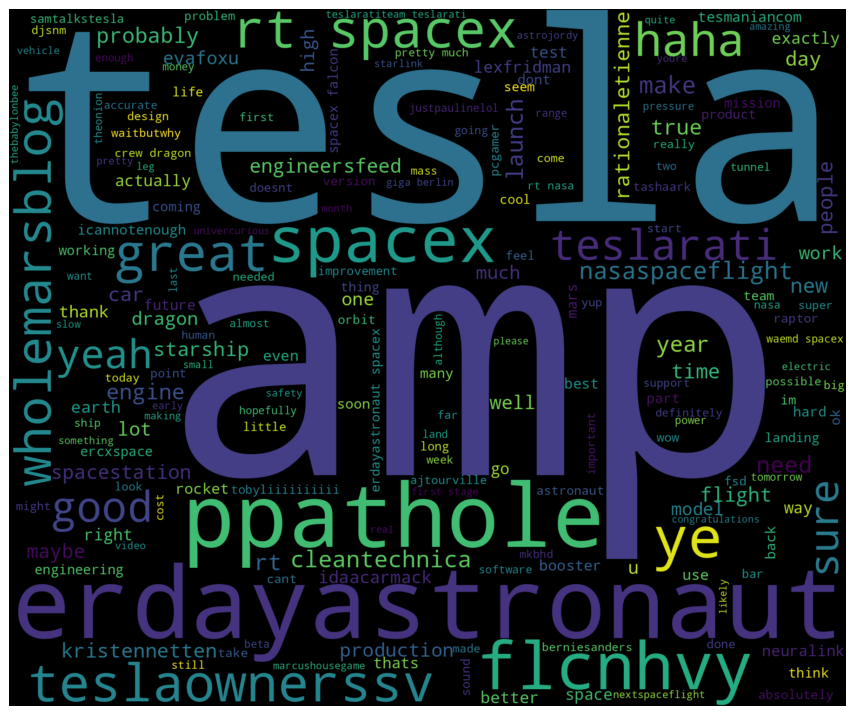

In [21]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

allwords = " ".join([twts for twts in tweets["Text"]])
wordCloud = WordCloud(width = 1800, height = 1500, random_state = 21).generate(allwords)
plt.figure(figsize=(12,12), dpi=90)
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [22]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [23]:
# Compute The Negative, Neutral, Positive Analysis
def analysis(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"

# Create a New Analysis Column
tweets["analysis"] = tweets["polarity"].apply(analysis)

In [24]:
positive_tweets = tweets[tweets['analysis'] == 'Positive']
negative_tweets = tweets[tweets['analysis'] == 'Negative']

print('positive tweets')
for i, row in positive_tweets[:5].iterrows():
    print(' -' + row['Text'])

print('negative tweets')
for i, row in negative_tweets[:5].iterrows():
    print(' -' + row['Text'])

positive tweets
 -joerogan spotify great interview
 -teslacn congratulations tesla china amazing execution last year next even
 -happy new year ox
 -owensparks flcnhvy haha thanks
 -entertaining outcome likely
negative tweets
 -im alien
 -frodo underdoge thought would fail httpstcozgxjfdzzrm
 -freewalletorg app sucks
 -rationaletienne adamklotz starlink staggeringly difficult technical amp economic endeavor however
 -rationaletienne adamklotz spacex needs pass deep chasm negative cash flow next year


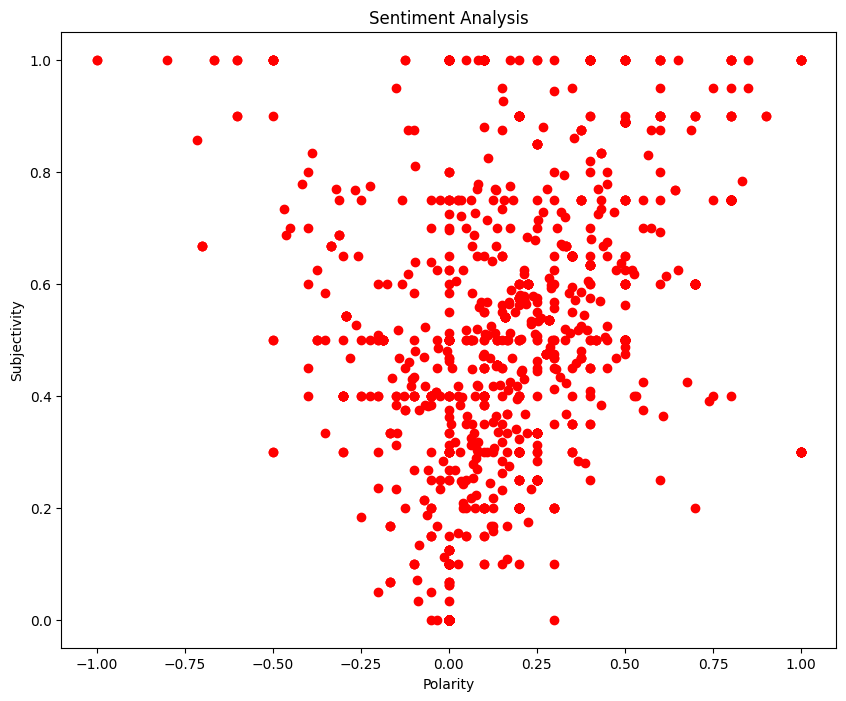

In [25]:
plt.figure(figsize=(10, 8))

for i in range(0, tweets.shape[0]):
    plt.scatter(tweets["polarity"][i], tweets["subjectivity"][i], color = "Red")

plt.title("Sentiment Analysis") # Add The Graph Title
plt.xlabel("Polarity") # Add The X-Label
plt.ylabel("Subjectivity") # Add The Y-Label
plt.show() # Showing The Graph

In [26]:
(len(positive_tweets) / len(negative_tweets))*100

422.11055276381904

### Conclusion: Since that number is positive, and quite high of a ratio, we can also conclude that Elon Musk is a positive guy.